# **TikTok Project**
**Course 6 - The Nuts and bolts of machine learning**

Recall that you are a data professional at TikTok. Your supervisor was impressed with the work you have done and has requested that you build a machine learning model that can be used to determine whether a video contains a claim or whether it offers an opinion. With a successful prediction model, TikTok can reduce the backlog of user reports and prioritize them more efficiently.

A notebook was structured and prepared to help you in this project. A notebook was structured and prepared to help you in this project. Please complete the following questions.

# **Course 6 End-of-course project: Classifying videos using machine learning**

In this activity, you will practice using machine learning techniques to predict on a binary outcome variable.
<br/>

**The purpose** of this model is to increase response time and system efficiency by automating the initial stages of the claims process.

**The goal** of this model is to predict whether a TikTok video presents a "claim" or presents an "opinion".
<br/>

*This activity has three parts:*

**Part 1:** Ethical considerations
* Consider the ethical implications of the request

* Should the objective of the model be adjusted?

**Part 2:** Feature engineering

* Perform feature selection, extraction, and transformation to prepare the data for modeling

**Part 3:** Modeling

* Build the models, evaluate them, and advise on next steps

Follow the instructions and answer the questions below to complete the activity. Then, you will complete an Executive Summary using the questions listed on the PACE Strategy Document.

Be sure to complete this activity before moving on. The next course item will provide you with a completed exemplar to compare to your own work.



# **Classify videos using machine learning**

<img src="../assets/Pace.png" width="100" height="100" align=left>

# **PACE stages**


Throughout these project notebooks, you'll see references to the problem-solving framework PACE. The following notebook components are labeled with the respective PACE stage: Plan, Analyze, Construct, and Execute.

<img src="../assets/Plan.png" width="100" height="100" align=left>


## **PACE: Plan**

Consider the questions in your PACE Strategy Document to reflect on the Plan stage.

In this stage, consider the following questions:


**Question 1a:** 

What are you being asked to do? 

**Answer 1a:** 

**Business need and modeling objective**

TikTok users can report videos that they believe violate the platform's terms of service. Because there are millions of TikTok videos created and viewed every day, this means that many videos get reported&mdash;too many to be individually reviewed by a human moderator.

Analysis indicates that when authors do violate the terms of service, they're much more likely to be presenting a claim than an opinion. Therefore, it is useful to be able to determine which videos make claims and which videos are opinions.

TikTok wants to build a machine learning model to help identify claims and opinions. Videos that are labeled opinions will be less likely to go on to be reviewed by a human moderator. Videos that are labeled as claims will be further sorted by a downstream process to determine whether they should get prioritized for review. For example, perhaps videos that are classified as claims would then be ranked by how many times they were reported, then the top x% would be reviewed by a human each day.

A machine learning model would greatly assist in the effort to present human moderators with videos that are most likely to be in violation of TikTok's terms of service.

**Modeling design and target variable**

The data dictionary shows that there is a column called `claim_status`. This is a binary value that indicates whether a video is a claim or an opinion. This will be the target variable. In other words, for each video, the model should predict whether the video is a claim or an opinion.

This is a classification task because the model is predicting a binary class.


**Question 1b:** 

What metric should I use to evaluate success of my business/organizational objective? 

**Answer 1b:** 

To determine which evaluation metric might be best, consider how the model might be wrong. There are two possibilities for bad predictions:

  - **False positives:** When the model predicts a video is a claim when in fact it is an opinion
  - **False negatives:** When the model predicts a video is an opinion when in fact it is a claim

**Question 2:** 

What are the ethical implications of the model? What are the consequences of your model making errors? What are the consequences of your model making errors?

**Answer 2:** 

In the given scenario, it's better for the model to predict false positives when it makes a mistake, and worse for it to predict false negatives. It's very important to identify videos that break the terms of service, even if that means some opinion videos are misclassified as claims. The worst case for an opinion misclassified as a claim is that the video goes to human review. The worst case for a claim that's misclassified as an opinion is that the video does not get reviewed _and_ it violates the terms of service. A video that violates the terms of service would be considered posted from a "banned" author, as referenced in the data dictionary.

Because it's more important to minimize false negatives, the model evaluation metric will be **recall**.

**Question 3:**  

How would you proceed?

**Answer 3:** 

Previous work with this data has revealed that there are ~20,000 videos in the sample. This is sufficient to conduct a rigorous model validation workflow, broken into the following steps:

1. Split the data into train/validation/test sets (60/20/20)
2. Fit models and tune hyperparameters on the training set
3. Perform final model selection on the validation set
4. Assess the champion model's performance on the test set

![](https://raw.githubusercontent.com/adacert/tiktok/main/optimal_model_flow_numbered.svg)

### **Task 1. Imports and data loading**

Start by importing packages needed to build machine learning models to achieve the goal of this project.

In [1]:
# Import packages for data manipulation
import numpy as np
import pandas as pd

# Import packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import packages for data preprocessing
from sklearn.feature_extraction.text import CountVectorizer

# Import packages for data modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, \
recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance

Now load the data from the provided csv file into a dataframe.

**Note:** As shown in this cell, the dataset has been automatically loaded in for you. You do not need to download the .csv file, or provide more code, in order to access the dataset and proceed with this lab. Please continue with this activity by completing the following instructions.

In [2]:
# Load dataset into dataframe
data = pd.read_csv("../datasets/tiktok_dataset.csv")

<img src="../assets/Analyze.png" width="100" height="100" align=left>

## **PACE: Analyze**

Consider the questions in your PACE Strategy Document to reflect on the Analyze stage.

### **Task 2: Examine data, summary info, and descriptive stats**

Inspect the first five rows of the dataframe.

In [3]:
# Display first few rows
data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


Get the number of rows and columns in the dataset.

In [4]:
# Get number of rows and columns
data.shape

(19382, 12)

Get the data types of the columns.

In [5]:
# Get data types of columns
data.dtypes

#                             int64
claim_status                 object
video_id                      int64
video_duration_sec            int64
video_transcription_text     object
verified_status              object
author_ban_status            object
video_view_count            float64
video_like_count            float64
video_share_count           float64
video_download_count        float64
video_comment_count         float64
dtype: object

Get basic information about the dataset.

In [6]:
# Get basic information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19382 entries, 0 to 19381
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         19382 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19382 non-null  int64  
 3   video_duration_sec        19382 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19382 non-null  object 
 6   author_ban_status         19382 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.8+ MB


Generate basic descriptive statistics about the dataset.

In [7]:
# Generate basic descriptive stats
data.describe()

,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
count,19382.000000,1.938200e+04,19382.000000,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000
mean,9691.500000,5.627454e+09,32.421732,254708.558688,84304.636030,16735.248323,1049.429627,349.312146
std,5595.245794,2.536440e+09,16.229967,322893.280814,133420.546814,32036.174350,2004.299894,799.638865
min,1.000000,1.234959e+09,5.000000,20.000000,0.000000,0.000000,0.000000,0.000000
25%,4846.250000,3.430417e+09,18.000000,4942.500000,810.750000,115.000000,7.000000,1.000000
50%,9691.500000,5.618664e+09,32.000000,9954.500000,3403.500000,717.000000,46.000000,9.000000
75%,14536.750000,7.843960e+09,47.000000,504327.000000,125020.000000,18222.000000,1156.250000,292.000000
max,19382.000000,9.999873e+09,60.000000,999817.000000,657830.000000,256130.000000,14994.000000,9599.000000


Check for and handle missing values.

In [8]:
# Check for missing values
data.isna().sum()

#                             0
claim_status                298
video_id                      0
video_duration_sec            0
video_transcription_text    298
verified_status               0
author_ban_status             0
video_view_count            298
video_like_count            298
video_share_count           298
video_download_count        298
video_comment_count         298
dtype: int64

In [9]:
# Drop rows with missing values
data = data.dropna()

Check for and handle duplicates.

In [10]:
# Check for duplicates
data.duplicated().sum()

0

Check for and handle outliers.

Tree-based models like random forest, xgboost are robust to outliers, so there is no need to impute or drop any values based on where they fall in their distribution.

Check class balance.

In [11]:
# Check class balance
data['claim_status'].value_counts()

claim_status
claim      9608
opinion    9476
Name: count, dtype: int64

In [12]:
# Check class balance by proportion
data['claim_status'].value_counts(normalize=True)

claim_status
claim      0.503458
opinion    0.496542
Name: proportion, dtype: float64

The outcome variable is rather balanced thus we do not need to resample

<img src="../assets/Construct.png" width="100" height="100" align=left>

## **PACE: Construct**
Consider the questions in your PACE Strategy Document to reflect on the Construct stage.

### **Task 3: Feature engineering**

Extract the length of each `video_transcription_text` and add this as a column to the dataframe, so that it can be used as a potential feature in the model.

In [13]:
# Extract the length of each `video_transcription_text` and add this as a column to the dataframe
data['video_text_length'] = data['video_transcription_text'].apply(lambda x : len(x))
data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,video_text_length
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,97
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,107
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,137
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,131
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,128


Calculate the average text_length for claims and opinions.

In [14]:
# Calculate the average text_length for claims and opinions
data['video_transcription_text'].apply(lambda x : len(x)).groupby(data['claim_status']).mean().reset_index()

,claim_status,video_transcription_text
0,claim,95.376978
1,opinion,82.722562


Visualize the distribution of `text_length` for claims and opinions.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


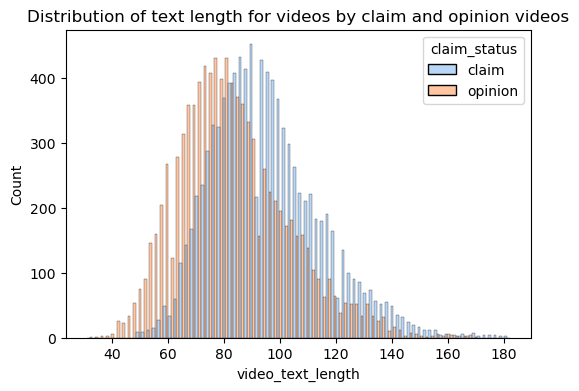

In [15]:
# Visualize the distribution of `text_length` for claims and opinions
# Create two histograms in one plot
plt.figure(figsize=(6,4))
sns.histplot(data=data, 
             x="video_text_length", 
             hue="claim_status",
             multiple="dodge", 
             palette="pastel")
plt.title("Distribution of text length for videos by claim and opinion videos")
plt.show()

The video_text_length for claim is on average more than opinion videos. Both the distribution are normal with some skewness to the right.

**Feature selection and transformation**

Encode target and catgorical variables.

In [16]:
# Create a copy of the X data
X = data.copy()
# Drop unnecessary columns
X = X.drop(['#', 'video_id', 'video_transcription_text'], axis=1)
# Encode target variable
X['claim_status'] = X['claim_status'].replace({'opinion': 0, 'claim': 1})
# Dummy encode remaining categorical values
X = pd.get_dummies(X, columns=['verified_status', 'author_ban_status'], drop_first=True)
X.head()

,claim_status,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,video_text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,1,59,343296.0,19425.0,241.0,1.0,0.0,97,False,False,True
1,1,32,140877.0,77355.0,19034.0,1161.0,684.0,107,False,False,False
2,1,31,902185.0,97690.0,2858.0,833.0,329.0,137,False,False,False
3,1,25,437506.0,239954.0,34812.0,1234.0,584.0,131,False,False,False
4,1,19,56167.0,34987.0,4110.0,547.0,152.0,128,False,False,False


### **Task 4: Split the data**

Assign target variable.

In [17]:
# Isolate target variable
y = X['claim_status']

Isolate the features.

In [18]:
# Isolate features
X = X.drop(['claim_status'], axis=1)
# Display first few rows of features dataframe
X.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,video_text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,59,343296.0,19425.0,241.0,1.0,0.0,97,False,False,True
1,32,140877.0,77355.0,19034.0,1161.0,684.0,107,False,False,False
2,31,902185.0,97690.0,2858.0,833.0,329.0,137,False,False,False
3,25,437506.0,239954.0,34812.0,1234.0,584.0,131,False,False,False
4,19,56167.0,34987.0,4110.0,547.0,152.0,128,False,False,False


#### **Task 5: Create train/validate/test sets**

Split data into training and testing sets, 80/20.

In [19]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Split the training set into training and validation sets, 75/25, to result in a final ratio of 60/20/20 for train/validate/test sets.

In [20]:
# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

Confirm that the dimensions of the training, validation, and testing sets are in alignment.

In [21]:
# Get shape of each training, validation, and testing set
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((11450, 10), (3817, 10), (3817, 10), (11450,), (3817,), (3817,))

### **Task 6. Build models**


### **Build a random forest model**

Fit a random forest model to the training set. Use cross-validation to tune the hyperparameters and select the model that performs best on recall.

In [22]:
# Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [5, 7, None],
             'max_features': [0.3, 0.6],
             'max_samples': [0.7],
             'min_samples_leaf': [1,2],
             'min_samples_split': [2,3],
             'n_estimators': [75,100,200],
             }

# Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='recall')

In [23]:
%%time
# Fit model with training set
rf_cv.fit(X_train, y_train)

CPU times: user 4min 6s, sys: 4.79 s, total: 4min 11s
Wall time: 4min 18s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [5, 7, None], 'max_features': [0.3, 0.6],
                         'max_samples': [0.7], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [75, 100, 200]},
             refit='recall', scoring={'precision', 'f1', 'accuracy', 'recall'})

In [24]:
# Examine best recall score
rf_cv.best_score_

0.9908534395531852

In [25]:
# Examine best parameters
rf_cv.best_params_

{'max_depth': 5,
 'max_features': 0.6,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 75}

In [26]:
def make_results(model_name, model_object):

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(mean f1 score)
    best_estimator_results = cv_results.iloc[cv_results['mean_test_f1'].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
  
    # Create table of results
    table = pd.DataFrame({'Model': [model_name],
                          'F1': [f1],
                          'Recall': [recall],
                          'Precision': [precision],
                          'Accuracy': [accuracy]
                         }
                        )
  
    return table

In [27]:
model_results = make_results('Random Forest', rf_cv)
model_results

,Model,F1,Recall,Precision,Accuracy
0,Random Forest,0.995143,0.990853,0.999479,0.995109


**Question:** 

How well is your model performing? Consider average recall score and precision score.  

**Answer:** 

The model is performing very well, with a recall score is 0.990853 or 99.1% across 5 cross validation folds and the precision is 0.999479

### **Build an XGBoost model**

In [28]:
# Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [4,8,12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300, 500]
             }

# Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='recall')

In [29]:
%%time
# Fit model with training set
xgb_cv.fit(X_train, y_train)

CPU times: user 2min 55s, sys: 1min 1s, total: 3min 57s
Wall time: 24.9 s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=0, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [4, 8, 12],
                         'min_child_weight': [3, 5],
                         'n_estimators': [300, 500]},
             refit='recall', scoring={'precision', 'f1', 'accuracy', 'recall'})

In [30]:
# Examine best recall score
xgb_cv.best_score_

0.9898176171763818

In [31]:
# Examine best parameters
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 5,
 'n_estimators': 300}

In [32]:
# Combine results of both models
model_results = pd.concat([make_results('XGBoost', xgb_cv), model_results]).sort_values(by=['Recall'], ascending=False).reset_index(drop=True)
model_results

,Model,F1,Recall,Precision,Accuracy
0,Random Forest,0.995143,0.990853,0.999479,0.995109
1,XGBoost,0.994620,0.989472,0.999825,0.994585


**Question:** 

How well does your model perform? Consider recall score and precision score. 

**Answer:** 

Both models performed very well but the recall score for the Random Forest model is higher

<img src="../assets/Execute.png" width="100" height="100" align=left>

## **PACE: Execute**
Consider the questions in your PACE Strategy Document to reflect on the Execute stage.

### **Task 7. Evaluate model**

Evaluate models against validation criteria.

#### **Random forest**

In [33]:
# Use the random forest "best estimator" model to get predictions on the encoded testing set
y_pred = rf_cv.best_estimator_.predict(X_val)

Display the predictions on the encoded testing set.

In [34]:
# Display the predictions on the encoded testing set
y_pred

array([1, 0, 1, ..., 1, 1, 1])

Display the true labels of the testing set.

In [35]:
# Display the true labels of the testing set
y_val

5846     1
12058    0
2975     1
8432     1
6863     1
        ..
6036     1
6544     1
2781     1
6426     1
4450     1
Name: claim_status, Length: 3817, dtype: int64

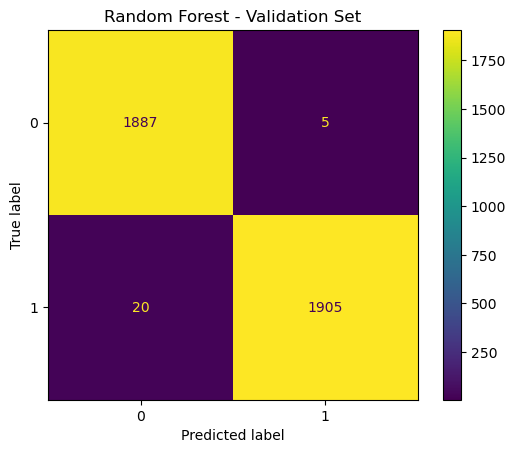

In [36]:
# Create a confusion matrix to visualize the results of the classification model

# Compute values for confusion matrix
log_cm = confusion_matrix(y_val, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.title('Random Forest - Validation Set')
plt.show()

Create a confusion matrix to visualize the results of the classification model.

- The upper-left quadrant displays the number of True Negatives: the number of opinions that the model accurately classified as so.

- The upper-right quadrant displays the number of False Positives: the number of opinions that the model misclassified as claims.

- The lower-left quadrant displays the number of False Negatives: the number of claims that the model misclassified as opinions.

- The lower-right quadrant displays the number of True Positives: the number of claims that the model accurately classified as so.

The model does not produce any False Negatives, which is what we want to minimize.

Create a classification report that includes precision, recall, f1-score, and accuracy metrics to evaluate the performance of the model.

In [37]:
# Create classification report for random forest model
target_labels = ['opinion', 'claim']
print(classification_report(y_val, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       0.99      1.00      0.99      1892
       claim       1.00      0.99      0.99      1925

    accuracy                           0.99      3817
   macro avg       0.99      0.99      0.99      3817
weighted avg       0.99      0.99      0.99      3817



**Question:** 

What does your classification report show? What does the confusion matrix indicate?  

**Answer:** 

The Random Forest model is almost perfect. The confusion matrix indicates that were 25 misclassifications (20 FN and 5 FP).

#### **XGBoost**

In [38]:
#Evaluate XGBoost model
y_pred = xgb_cv.best_estimator_.predict(X_val)

In [39]:
y_pred

array([1, 0, 1, ..., 1, 1, 1])

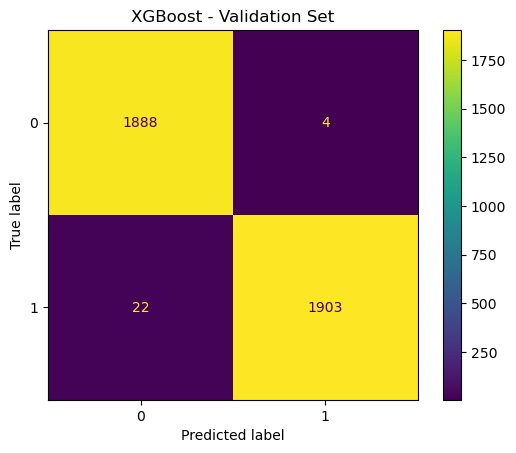

In [40]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_val, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.title('XGBoost - Validation Set')
plt.show()

In [41]:
# Create a classification report for xgboost
target_labels = ['opinion', 'claim']
print(classification_report(y_val, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       0.99      1.00      0.99      1892
       claim       1.00      0.99      0.99      1925

    accuracy                           0.99      3817
   macro avg       0.99      0.99      0.99      3817
weighted avg       0.99      0.99      0.99      3817



**Question:** 

Describe your XGBoost model results. How does your XGBoost model compare to your random forest model?  

**Answer:** 

The XGBoost model is also almost perfect with a recall score of 0.99.

The Random Forest model have lesser FN (20 vs 22) which is better since FN can lead to a claim being misclassified as an opinion which does not get reviewed at all despite violating the terms of service, and should thus be minimised. Thus the random forest model is the champion model.

### **Use champion model to predict on test data**

In [42]:
# Random Forest is the champion model so we will use that on the test data
y_pred = rf_cv.best_estimator_.predict(X_test)

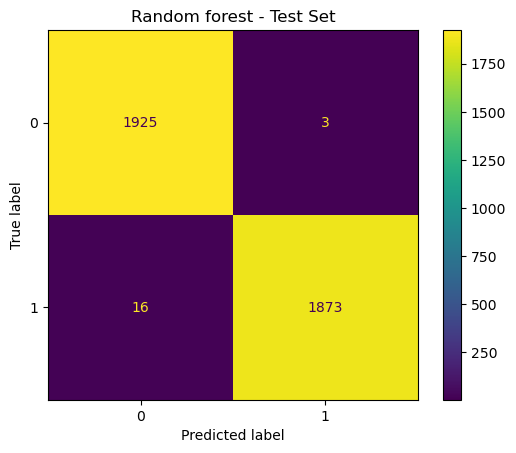

In [43]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.title('Random forest - Test Set')
plt.show()


#### **Feature importances of champion model**

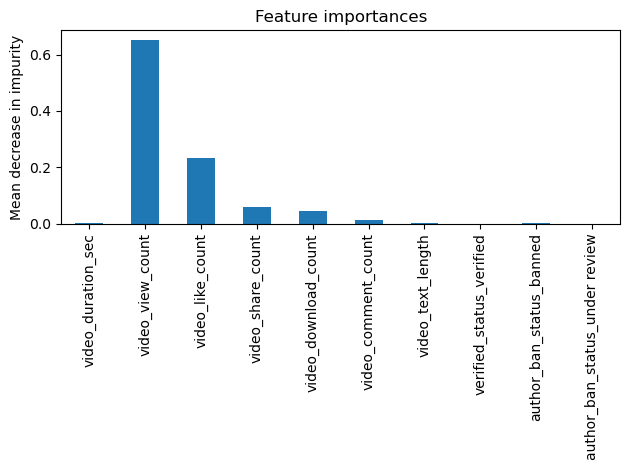

In [44]:
importances = rf_cv.best_estimator_.feature_importances_
rf_importances = pd.Series(importances, index=X_test.columns)

fig, ax = plt.subplots()
rf_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()

**Question:** 

Describe your most predictive features. Were your results surprising?  

**Answer:** 

The most predictive feature are all related to video engagement metrics with the best predictor being `video_view_count`. This aligns with previous EDA findings.

### **Task 8. Conclusion**

In this step use the results of the models above to formulate a conclusion. Consider the following questions:

**Question:**

1. **Would you recommend using this model? Why or why not?**

2. **What was your model doing? Can you explain how it was making predictions?**

3. **Are there new features that you can engineer that might improve model performance?**

4. **What features would you want to have that would likely improve the performance of your model?**

Remember, sometimes your data simply will not be predictive of your chosen target. This is common. Machine learning is a powerful tool, but it is not magic. If your data does not contain predictive signal, even the most complex algorithm will not be able to deliver consistent and accurate predictions. Do not be afraid to draw this conclusion.


**Answers:**

**1. Would you recommend using this model? Why or why not?**  
Yes, I would recommend the final model because it performed well on both the validation and test data. Furthermore, both precision and F<sub>1</sub> scores were consistently high. The model very successfully classified claims and opinions.

**2. What was your model doing? Can you explain how it was making predictions?**  
The model's most predictive features were all related to the user engagement levels associated with each video. It was classifying videos based on how many views, likes, shares, and downloads they received.

**3. Are there new features that you can engineer that might improve model performance?**
As the model currently has near perfect performance, there is no need to introduce new features to complicate things.

**4. What features would you want to have that would likely improve the performance of your model?**
The current version of the model does not need any new features. However, it would be helpful to have other information such as the number of times the video was reported.